In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
import torchvision
import torch.nn.functional as F
from torch.autograd import Variable

from PIL import Image
import cv2
import albumentations as A

import time
import os
from tqdm import tqdm

from torchsummary import summary
import segmentation_models_pytorch as smp

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

/home/umar/miniconda3/envs/firefly/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Defining Dataloader

Index paths into Dataframe for easier lookup

In [2]:
base_dir = "/home/umar/Documents/uwaterloo/4b/capstone_firefly/local_sandbox/FLAME/"
image_base_dir = os.path.join(base_dir, "Images")
mask_base_dir = os.path.join(base_dir, "Masks")

print("Image base dir: ", image_base_dir)
print("Mask base dir: ", mask_base_dir)

Image base dir:  /home/umar/Documents/uwaterloo/4b/capstone_firefly/local_sandbox/FLAME/Images
Mask base dir:  /home/umar/Documents/uwaterloo/4b/capstone_firefly/local_sandbox/FLAME/Masks


In [3]:
n_classes = 2

def create_df():
    name = []
    for _, _, filenames in os.walk(image_base_dir):
        for filename in filenames:
            name.append(filename.split('.')[0].split('_')[1])
    
    return pd.DataFrame({'id': name}, index = np.arange(0, len(name)))

df = create_df()
print('Total Images: ', len(df))
df.head()

Total Images:  2003


,id
0,1694
1,96
2,1089
3,1026
4,719


Split image and mask paths into train/val/test

In [4]:
X_trainval, X_test = train_test_split(df['id'].values, test_size=0.1, random_state=19)
X_train, X_val = train_test_split(X_trainval, test_size=0.15, random_state=19)

print('Train Size   : ', len(X_train))
print('Val Size     : ', len(X_val))
print('Test Size    : ', len(X_test))

sum_of_splits = len(X_train) + len(X_val) + len(X_test)
print("\nSum of training, validation and test images: ", sum_of_splits)
if sum_of_splits == len(df):
    print("\nNice. The sum of the training, validation and test images is equal to the total number of images.")
else:
    print("\n!!Warning, The sum of the training, validation and test images is not equal to the total number of images.")

Train Size   :  1531
Val Size     :  271
Test Size    :  201

Sum of training, validation and test images:  2003

Nice. The sum of the training, validation and test images is equal to the total number of images.


Image Size (2160, 3840, 3)
Mask Size (2160, 3840)


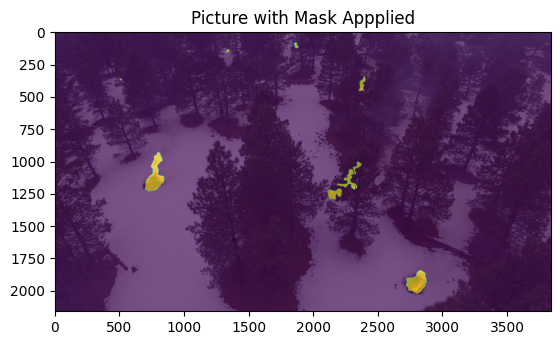

In [5]:
img = cv2.imread(os.path.join(image_base_dir, "image_" + df['id'][100] + '.jpg'))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
mask = cv2.imread(os.path.join(mask_base_dir, "image_" + df['id'][100] + '.png'), cv2.IMREAD_GRAYSCALE)
print('Image Size', np.asarray(img).shape)
print('Mask Size', np.asarray(mask).shape)


plt.imshow(img)
plt.imshow(mask, alpha=0.6)
plt.title('Picture with Mask Appplied')
plt.show()

In [6]:
class FLAMEDataset(Dataset):
    
    def __init__(self, img_path, mask_path, X, mean, std, transform=None, patch=False):
        self.img_path = img_path
        self.mask_path = mask_path
        self.X = X
        self.transform = transform
        self.patches = patch
        self.mean = mean
        self.std = std
        
    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        img = cv2.imread(os.path.join(image_base_dir, "image_" + str(self.X[idx]) + '.jpg'))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(os.path.join(mask_base_dir, "image_" + str(self.X[idx]) + '.png'), cv2.IMREAD_GRAYSCALE)
        
        if self.transform is not None:
            aug = self.transform(image=img, mask=mask)
            img = Image.fromarray(aug['image'])
            mask = aug['mask']
        
        if self.transform is None:
            img = Image.fromarray(img)

        t = T.Compose([T.ToTensor(), T.Normalize(self.mean, self.std)])
        # img = pad_img_till_dims_by_32(t(img))
        # mask = pad_img_till_dims_by_32(torch.from_numpy(mask).long())

        img = t(img)
        mask = torch.from_numpy(mask).long()

        if self.patches:
            img, mask = self.tiles(img, mask)
        return img, mask
    
    def tiles(self, img, mask):

        img_patches = img.unfold(1, 512, 512).unfold(2, 768, 768) 
        img_patches  = img_patches.contiguous().view(3,-1, 512, 768) 
        img_patches = img_patches.permute(1,0,2,3)
        
        mask_patches = mask.unfold(0, 512, 512).unfold(1, 768, 768)
        mask_patches = mask_patches.contiguous().view(-1, 512, 768)
        
        return img_patches, mask_patches

In [7]:
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]

t_train = A.Compose([A.Resize(704, 1056, interpolation=cv2.INTER_NEAREST), A.HorizontalFlip(), A.VerticalFlip(), 
                     A.GridDistortion(p=0.2), A.RandomBrightnessContrast((0,0.5),(0,0.5)),
                     A.GaussNoise()])

t_val = A.Compose([A.Resize(704, 1056, interpolation=cv2.INTER_NEAREST), A.HorizontalFlip(),
                   A.GridDistortion(p=0.2)])

#datasets
train_set = FLAMEDataset(image_base_dir, mask_base_dir, X_train, mean, std, t_train, patch=False)
val_set = FLAMEDataset(image_base_dir, mask_base_dir, X_val, mean, std, t_val, patch=False)

In [ ]:
# a large batch size can lead to poor generalization, but small batch sizes may not fully utilize the GPU
# https://towardsdatascience.com/a-batch-too-large-finding-the-batch-size-that-fits-on-gpus-aef70902a9f1 
import typing as t
def get_batch_size(
    model: nn.Module,
    device: torch.device,
    input_shape: t.Tuple[int, int, int],
    output_shape: t.Tuple[int],
    dataset_size: int,
    max_batch_size: int = None,
    num_iterations: int = 5,
) -> int:
    model.to(device)
    model.train(True)
    optimizer = torch.optim.AdamW(model.parameters())

    batch_size = 2
    while True:
        if max_batch_size is not None and batch_size >= max_batch_size:
            batch_size = max_batch_size
            break
        if batch_size >= dataset_size:
            batch_size = batch_size // 2
            break
        try:
            for _ in range(num_iterations):
                # dummy inputs and targets
                inputs = torch.rand(*(batch_size, *input_shape), device=device)
                targets = torch.rand(*(batch_size, *output_shape), device=device)
                outputs = model(inputs)
                loss = F.mse_loss(targets, outputs)
                loss.backward()
                optimizer.step()
                optimizer.zero_grad()
            batch_size *= 2
        except RuntimeError:
            batch_size //= 2
            break
    del model, optimizer
    torch.cuda.empty_cache()
    print("Calculated Batch size: ", batch_size)
    return batch_size

In [14]:
model = smp.Unet('mobilenet_v2', encoder_weights='imagenet', classes=n_classes, activation=None, encoder_depth=5, decoder_channels=[256, 128, 64, 32, 16])

#dataloader
try:
    batch_size = get_batch_size(model, device, (3, 704, 1056), (n_classes, 704, 1056), len(X_trainval)+len(X_test), max_batch_size=16, num_iterations=5)
except:
    batch_size = 3

print("Used Batch size: ", batch_size)

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=True)    

# model

Calculated Batch size:  2
Used Batch size:  2


In [ ]:
summary(model, (3, 704, 1056), batch_size=batch_size)


# Training

In [9]:
def pixel_accuracy(output, mask):
    with torch.no_grad():
        output = torch.argmax(F.softmax(output, dim=1), dim=1)
        correct = torch.eq(output, mask).int()
        accuracy = float(correct.sum()) / float(correct.numel())
    return accuracy

def mIoU(pred_mask, mask, smooth=1e-10, n_classes=n_classes):
    with torch.no_grad():
        pred_mask = F.softmax(pred_mask, dim=1)
        pred_mask = torch.argmax(pred_mask, dim=1)
        pred_mask = pred_mask.contiguous().view(-1)
        mask = mask.contiguous().view(-1)

        iou_per_class = []
        for clas in range(0, n_classes): #loop per pixel class
            true_class = pred_mask == clas
            true_label = mask == clas

            if true_label.long().sum().item() == 0: #no exist label in this loop
                iou_per_class.append(np.nan)
            else:
                intersect = torch.logical_and(true_class, true_label).sum().float().item()
                union = torch.logical_or(true_class, true_label).sum().float().item()

                iou = (intersect + smooth) / (union +smooth)
                iou_per_class.append(iou)
        return np.nanmean(iou_per_class)

In [10]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit(epochs, model, train_loader, val_loader, criterion, optimizer, scheduler, patch=False):
    torch.cuda.empty_cache()
    train_losses = []
    test_losses = []
    val_iou = []; val_acc = []
    train_iou = []; train_acc = []
    lrs = []
    min_loss = np.inf
    decrease = 1 ; not_improve=0

    model.to(device)
    print('Training started...')
    fit_time = time.time()
    for e in range(epochs):
        since = time.time()
        running_loss = 0
        iou_score = 0
        accuracy = 0
        #training loop
        model.train()
        for i, data in enumerate(tqdm(train_loader)):
            # print("Gathering data...")
            #training phase
            image_tiles, mask_tiles = data
            if patch:
                bs, n_tiles, c, h, w = image_tiles.size()

                image_tiles = image_tiles.view(-1,c, h, w)
                mask_tiles = mask_tiles.view(-1, h, w)
            
            image = image_tiles.to(device); mask = mask_tiles.to(device);
            #forward
            # print("Forwarding...")
            output = model(image)
            loss = criterion(output, mask)
            #evaluation metrics
            # print("Evaluating...")
            iou_score += mIoU(output, mask)
            accuracy += pixel_accuracy(output, mask)
            #backward
            # print("Backward...")
            loss.backward()
            optimizer.step() #update weight          
            optimizer.zero_grad() #reset gradient
            
            #step the learning rate
            # print("Step the Learning rate...")
            lrs.append(get_lr(optimizer))
            scheduler.step() 
            
            running_loss += loss.item()
            
        else:
            model.eval()
            test_loss = 0
            test_accuracy = 0
            val_iou_score = 0
            #validation loop
            with torch.no_grad():
                for i, data in enumerate(tqdm(val_loader)):
                    #reshape to 9 patches from single image, delete batch size
                    image_tiles, mask_tiles = data

                    if patch:
                        bs, n_tiles, c, h, w = image_tiles.size()

                        image_tiles = image_tiles.view(-1,c, h, w)
                        mask_tiles = mask_tiles.view(-1, h, w)
                    
                    image = image_tiles.to(device); mask = mask_tiles.to(device);
                    output = model(image)
                    #evaluation metrics
                    val_iou_score +=  mIoU(output, mask)
                    test_accuracy += pixel_accuracy(output, mask)
                    #loss
                    loss = criterion(output, mask)                                  
                    test_loss += loss.item()
            
            #calculatio mean for each batch
            train_losses.append(running_loss/len(train_loader))
            test_losses.append(test_loss/len(val_loader))


            if min_loss > (test_loss/len(val_loader)):
                print('Loss Decreasing.. {:.3f} >> {:.3f} '.format(min_loss, (test_loss/len(val_loader))))
                min_loss = (test_loss/len(val_loader))
                decrease += 1
                if decrease % 5 == 0:
                    print('saving model...')
                    torch.save(model, 'Unet-Mobilenet_v2_mIoU-{:.3f}.pt'.format(val_iou_score/len(val_loader)))
                    

            if (test_loss/len(val_loader)) > min_loss:
                not_improve += 1
                min_loss = (test_loss/len(val_loader))
                print(f'Loss Not Decrease for {not_improve} time')
                if not_improve == 7:
                    print('Loss not decrease for 7 times, Stop Training')
                    break
            
            #iou
            val_iou.append(val_iou_score/len(val_loader))
            train_iou.append(iou_score/len(train_loader))
            train_acc.append(accuracy/len(train_loader))
            val_acc.append(test_accuracy/ len(val_loader))
            print("Epoch:{}/{}..".format(e+1, epochs),
                  "Train Loss: {:.3f}..".format(running_loss/len(train_loader)),
                  "Val Loss: {:.3f}..".format(test_loss/len(val_loader)),
                  "Train mIoU:{:.3f}..".format(iou_score/len(train_loader)),
                  "Val mIoU: {:.3f}..".format(val_iou_score/len(val_loader)),
                  "Train Acc:{:.3f}..".format(accuracy/len(train_loader)),
                  "Val Acc:{:.3f}..".format(test_accuracy/len(val_loader)),
                  "Time: {:.2f}m".format((time.time()-since)/60))
        
    history = {'train_loss' : train_losses, 'val_loss': test_losses,
               'train_miou' :train_iou, 'val_miou':val_iou,
               'train_acc' :train_acc, 'val_acc':val_acc,
               'lrs': lrs}
    print('Total time: {:.2f} m' .format((time.time()- fit_time)/60))
    return history

In [17]:
max_lr = 1e-3
epoch = 15
weight_decay = 1e-4

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=max_lr, weight_decay=weight_decay)
sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epoch,
                                            steps_per_epoch=len(train_loader))

history = fit(epoch, model, train_loader, val_loader, criterion, optimizer, sched)

Training started...


100%|██████████| 136/136 [00:29<00:00,  4.61it/s]


Loss Decreasing.. inf >> 0.028 
Epoch:1/15.. Train Loss: 0.161.. Val Loss: 0.028.. Train mIoU:0.648.. Val mIoU: 0.840.. Train Acc:0.987.. Val Acc:0.998.. Time: 5.01m


100%|██████████| 136/136 [00:29<00:00,  4.66it/s]


Loss Decreasing.. 0.028 >> 0.007 
Epoch:2/15.. Train Loss: 0.014.. Val Loss: 0.007.. Train mIoU:0.824.. Val mIoU: 0.867.. Train Acc:0.998.. Val Acc:0.998.. Time: 4.94m


100%|██████████| 136/136 [00:29<00:00,  4.56it/s]


Loss Decreasing.. 0.007 >> 0.005 
Epoch:3/15.. Train Loss: 0.007.. Val Loss: 0.005.. Train mIoU:0.840.. Val mIoU: 0.876.. Train Acc:0.998.. Val Acc:0.998.. Time: 4.95m


100%|██████████| 136/136 [00:30<00:00,  4.48it/s]


Loss Decreasing.. 0.005 >> 0.004 
saving model...
Epoch:4/15.. Train Loss: 0.006.. Val Loss: 0.004.. Train mIoU:0.846.. Val mIoU: 0.875.. Train Acc:0.998.. Val Acc:0.998.. Time: 5.01m


100%|██████████| 136/136 [00:29<00:00,  4.60it/s]


Loss Decreasing.. 0.004 >> 0.004 
Epoch:5/15.. Train Loss: 0.005.. Val Loss: 0.004.. Train mIoU:0.852.. Val mIoU: 0.884.. Train Acc:0.998.. Val Acc:0.998.. Time: 5.07m


100%|██████████| 136/136 [00:29<00:00,  4.59it/s]


Loss Not Decrease for 1 time
Epoch:6/15.. Train Loss: 0.005.. Val Loss: 0.004.. Train mIoU:0.857.. Val mIoU: 0.878.. Train Acc:0.998.. Val Acc:0.998.. Time: 5.06m


100%|██████████| 136/136 [00:30<00:00,  4.53it/s]


Loss Decreasing.. 0.004 >> 0.004 
Epoch:7/15.. Train Loss: 0.005.. Val Loss: 0.004.. Train mIoU:0.858.. Val mIoU: 0.882.. Train Acc:0.998.. Val Acc:0.998.. Time: 5.09m


100%|██████████| 136/136 [00:30<00:00,  4.53it/s]


Loss Decreasing.. 0.004 >> 0.004 
Epoch:8/15.. Train Loss: 0.005.. Val Loss: 0.004.. Train mIoU:0.859.. Val mIoU: 0.887.. Train Acc:0.998.. Val Acc:0.999.. Time: 5.08m


100%|██████████| 136/136 [00:30<00:00,  4.53it/s]


Loss Not Decrease for 2 time
Epoch:9/15.. Train Loss: 0.005.. Val Loss: 0.004.. Train mIoU:0.864.. Val mIoU: 0.887.. Train Acc:0.998.. Val Acc:0.999.. Time: 5.11m


100%|██████████| 136/136 [00:30<00:00,  4.52it/s]


Loss Decreasing.. 0.004 >> 0.003 
Epoch:10/15.. Train Loss: 0.004.. Val Loss: 0.003.. Train mIoU:0.872.. Val mIoU: 0.886.. Train Acc:0.998.. Val Acc:0.999.. Time: 5.10m


100%|██████████| 136/136 [00:29<00:00,  4.54it/s]


Loss Decreasing.. 0.003 >> 0.003 
saving model...
Epoch:11/15.. Train Loss: 0.004.. Val Loss: 0.003.. Train mIoU:0.874.. Val mIoU: 0.894.. Train Acc:0.998.. Val Acc:0.999.. Time: 5.16m


100%|██████████| 136/136 [00:30<00:00,  4.50it/s]


Loss Not Decrease for 3 time
Epoch:12/15.. Train Loss: 0.004.. Val Loss: 0.003.. Train mIoU:0.875.. Val mIoU: 0.891.. Train Acc:0.998.. Val Acc:0.999.. Time: 5.14m


100%|██████████| 136/136 [00:29<00:00,  4.57it/s]


Loss Decreasing.. 0.003 >> 0.003 
Epoch:13/15.. Train Loss: 0.004.. Val Loss: 0.003.. Train mIoU:0.881.. Val mIoU: 0.897.. Train Acc:0.999.. Val Acc:0.999.. Time: 5.10m


100%|██████████| 136/136 [00:29<00:00,  4.60it/s]


Loss Decreasing.. 0.003 >> 0.003 
Epoch:14/15.. Train Loss: 0.004.. Val Loss: 0.003.. Train mIoU:0.884.. Val mIoU: 0.900.. Train Acc:0.999.. Val Acc:0.999.. Time: 5.00m


100%|██████████| 136/136 [00:30<00:00,  4.50it/s]

Loss Not Decrease for 4 time
Epoch:15/15.. Train Loss: 0.004.. Val Loss: 0.003.. Train mIoU:0.885.. Val mIoU: 0.901.. Train Acc:0.999.. Val Acc:0.999.. Time: 5.09m
Total time: 75.91 m


In [18]:
torch.save(model, 'FLAME-Unet-Mobilenet-AdamW-class2-epoch15-batch3.pt')

In [19]:
def plot_loss(history):
    plt.plot(history['val_loss'], label='val', marker='o')
    plt.plot( history['train_loss'], label='train', marker='o')
    plt.title('Loss per epoch'); plt.ylabel('loss');
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()
    
def plot_score(history):
    plt.plot(history['train_miou'], label='train_mIoU', marker='*')
    plt.plot(history['val_miou'], label='val_mIoU',  marker='*')
    plt.title('Score per epoch'); plt.ylabel('mean IoU')
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()
    
def plot_acc(history):
    plt.plot(history['train_acc'], label='train_accuracy', marker='*')
    plt.plot(history['val_acc'], label='val_accuracy',  marker='*')
    plt.title('Accuracy per epoch'); plt.ylabel('Accuracy')
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()

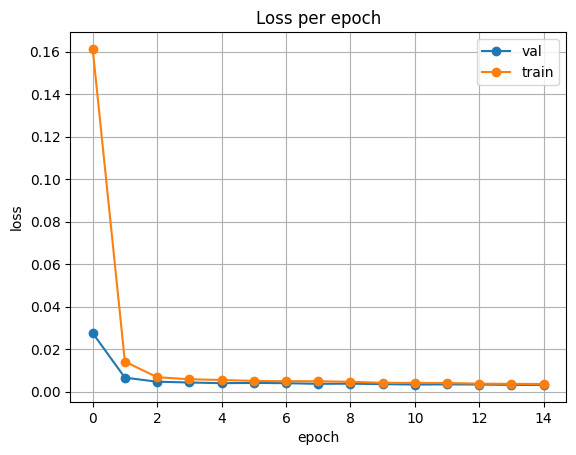

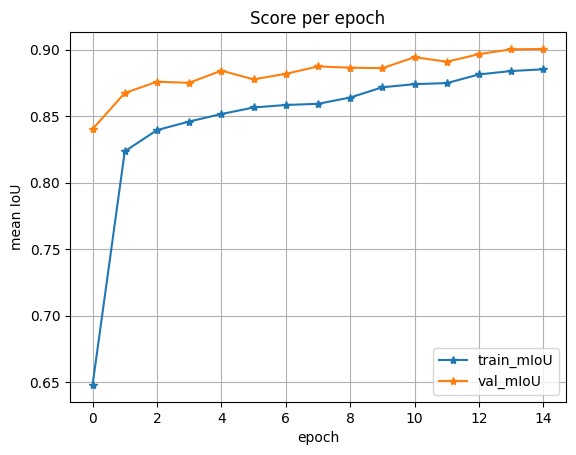

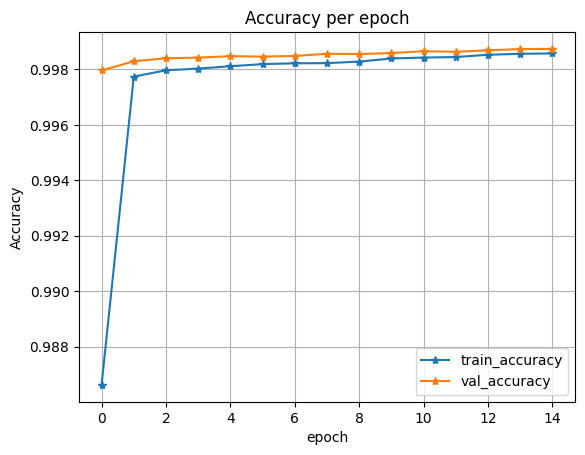

In [20]:
plot_loss(history)
plot_score(history)
plot_acc(history)

In [21]:
class FLAMETestDataset(Dataset):
    def __init__(self, img_path, mask_path, X, transform=None):
        self.img_path = img_path
        self.mask_path = mask_path
        self.X = X
        self.transform = transform

    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        img = cv2.imread(os.path.join(image_base_dir, "image_" + str(self.X[idx]) + '.jpg'))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(os.path.join(mask_base_dir, "image_" + str(self.X[idx]) + '.png'), cv2.IMREAD_GRAYSCALE)
        
        if self.transform is not None:
            aug = self.transform(image=img, mask=mask)
            img = Image.fromarray(aug['image'])
            mask = aug['mask']
        
        if self.transform is None:
            img = Image.fromarray(img)
        
        mask = torch.from_numpy(mask).long()
        
        return img, mask

t_test = A.Resize(768, 1152, interpolation=cv2.INTER_NEAREST)
test_set = FLAMETestDataset(image_base_dir, mask_base_dir, X_test, transform=t_test)

# Result

In [33]:
def predict_image_mask_miou(model, image, mask, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    model.eval()
    t = T.Compose([T.ToTensor(), T.Normalize(mean, std)])
    image = t(image)
    model.to(device); image=image.to(device)
    mask = mask.to(device)
    with torch.no_grad():
        
        image = image.unsqueeze(0)
        mask = mask.unsqueeze(0)
        
        output = model(image)
        score = mIoU(output, mask)
        masked = torch.argmax(output, dim=1)
        masked = masked.cpu().squeeze(0)
    return masked, score

def predict_image_mask_pixel(model, image, mask, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    model.eval()
    t = T.Compose([T.ToTensor(), T.Normalize(mean, std)])
    image = t(image)
    model.to(device); image=image.to(device)
    mask = mask.to(device)
    with torch.no_grad():
        
        image = image.unsqueeze(0)
        mask = mask.unsqueeze(0)
        
        output = model(image)
        acc = pixel_accuracy(output, mask)
        masked = torch.argmax(output, dim=1)
        masked = masked.cpu().squeeze(0)
    return masked, acc


def inference_flame_model(model, image, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    model.eval()
    t = T.Compose([T.ToTensor(), T.Normalize(mean, std)])
    image = t(image)
    model.to(device); image=image.to(device)
    
    with torch.no_grad():
        image = image.unsqueeze(0)
        output = model(image)
        masked = torch.argmax(output, dim=1)
        masked = masked.cpu().squeeze(0)
    return masked

In [24]:
def miou_score(model, test_set):
    score_iou = []
    for i in tqdm(range(len(test_set))):
        img, mask = test_set[i]
        pred_mask, score = predict_image_mask_miou(model, img, mask)
        score_iou.append(score)
    return score_iou

def pixel_acc(model, test_set):
    accuracy = []
    for i in tqdm(range(len(test_set))):
        img, mask = test_set[i]
        pred_mask, acc = predict_image_mask_pixel(model, img, mask)
        accuracy.append(acc)
    return accuracy

In [25]:
mob_miou = miou_score(model, test_set)

100%|██████████| 201/201 [00:23<00:00,  8.38it/s]


In [27]:
mob_acc = pixel_acc(model, test_set)

100%|██████████| 201/201 [00:23<00:00,  8.50it/s]


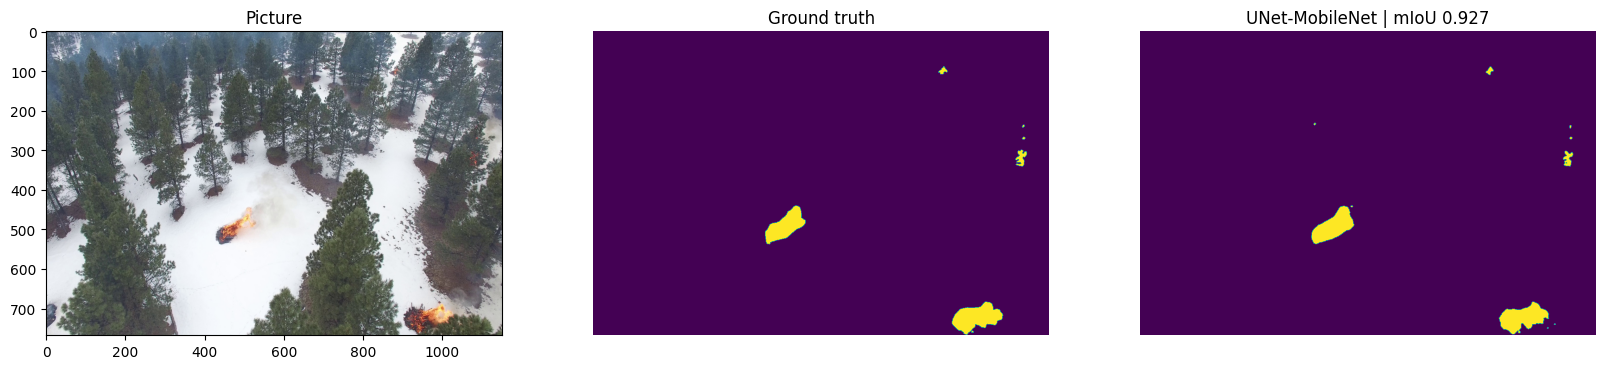

In [28]:
image, mask = test_set[3]
pred_mask, score = predict_image_mask_miou(model, image, mask)

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,10))
ax1.imshow(image)
ax1.set_title('Picture');

ax2.imshow(mask)
ax2.set_title('Ground truth')
ax2.set_axis_off()

ax3.imshow(pred_mask)
ax3.set_title('UNet-MobileNet | mIoU {:.3f}'.format(score))
ax3.set_axis_off()

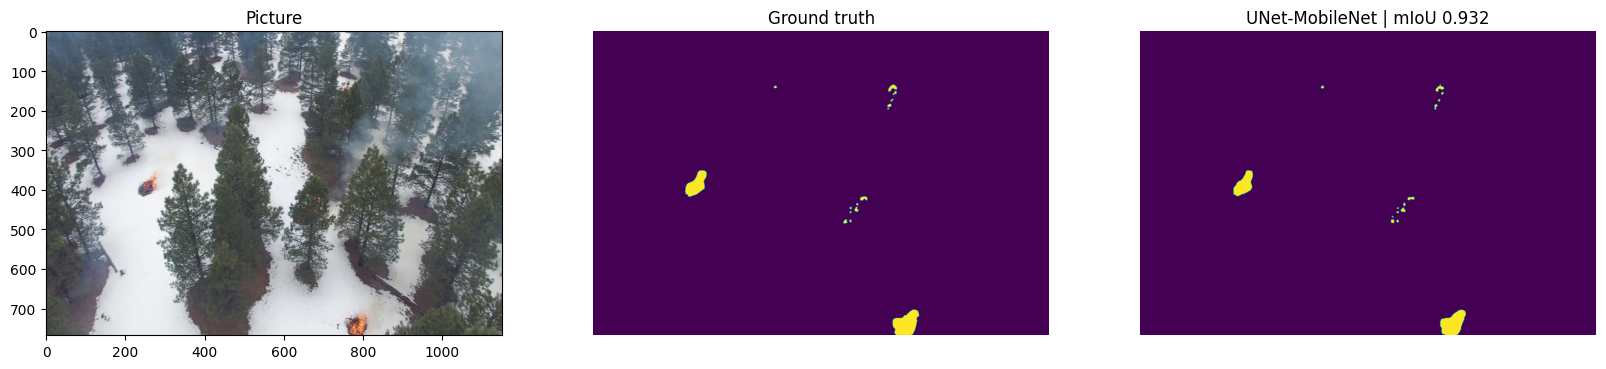

In [29]:
image2, mask2 = test_set[4]
pred_mask2, score2 = predict_image_mask_miou(model, image2, mask2)

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,10))
ax1.imshow(image2)
ax1.set_title('Picture');

ax2.imshow(mask2)
ax2.set_title('Ground truth')
ax2.set_axis_off()

ax3.imshow(pred_mask2)
ax3.set_title('UNet-MobileNet | mIoU {:.3f}'.format(score2))
ax3.set_axis_off()

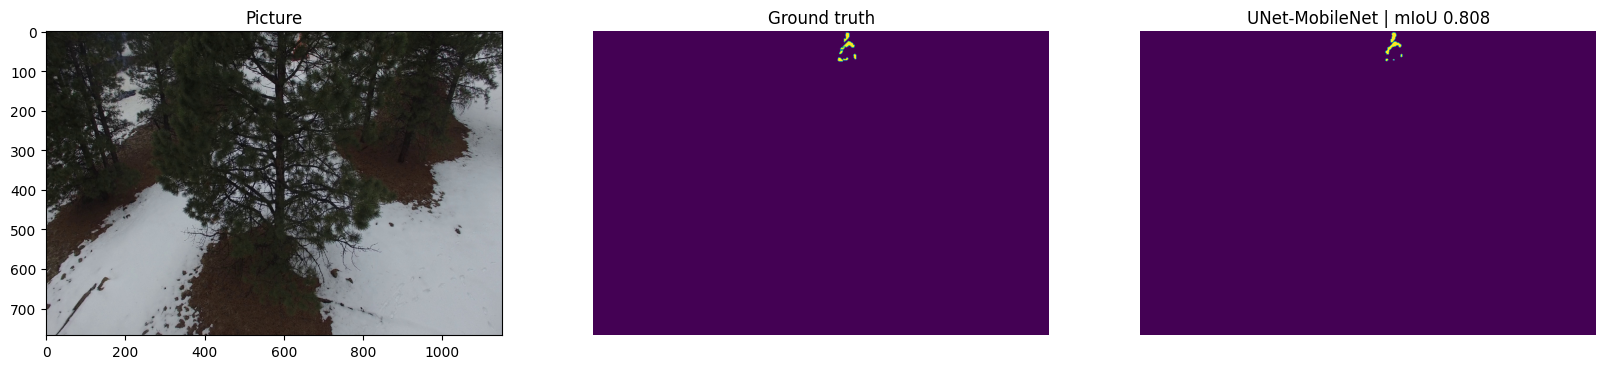

In [30]:
image3, mask3 = test_set[6]
pred_mask3, score3 = predict_image_mask_miou(model, image3, mask3)

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,10))
ax1.imshow(image3)
ax1.set_title('Picture');

ax2.imshow(mask3)
ax2.set_title('Ground truth')
ax2.set_axis_off()

ax3.imshow(pred_mask3)
ax3.set_title('UNet-MobileNet | mIoU {:.3f}'.format(score3))
ax3.set_axis_off()

In [31]:
print('Test Set mIoU', np.mean(mob_miou))

Test Set mIoU 0.898076590822995


In [32]:
print('Test Set Pixel Accuracy', np.mean(mob_acc))

Test Set Pixel Accuracy 0.9988525064474357


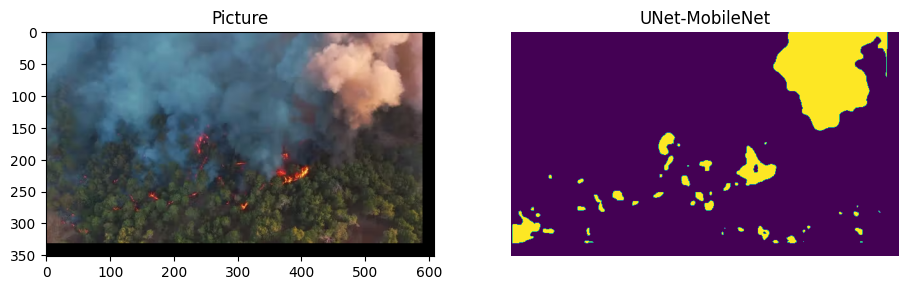

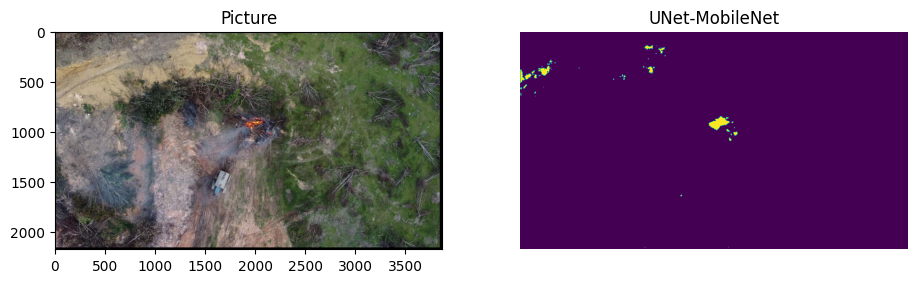

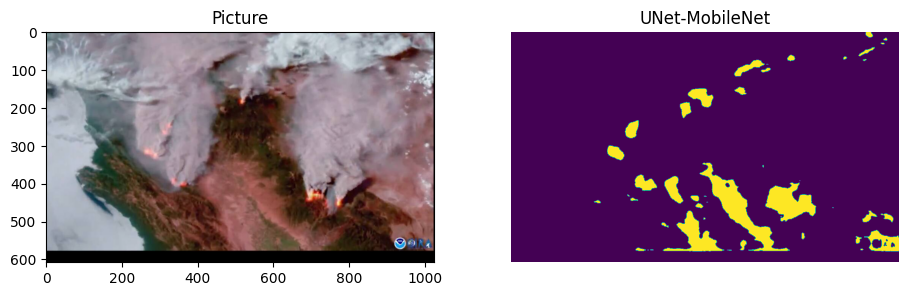

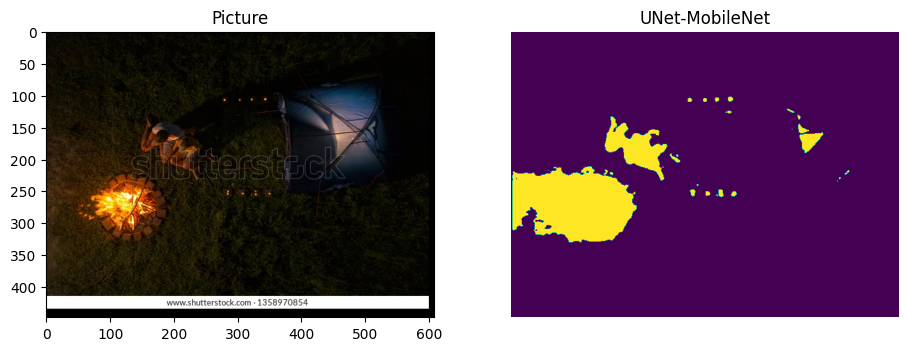

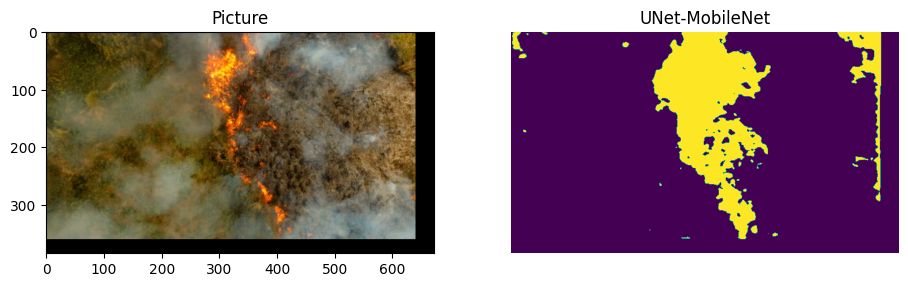

In [45]:
# Check if both the height and width are divisible by 32
# If not, pad the image with zeros until both the height and width are divisible by 32
def pad_torch_img_till_dims_by_32(img):
    # Get the shape of the image
    w, h = T.functional.get_image_size(img)
    # Calculate the number of pixels to pad
    pad_h = 32 - h % 32
    pad_w = 32 - w % 32
    # Pad the image
    img = F.pad(img, (0, pad_w, 0, pad_h))
    return img

def pad_numpy_img_till_dims_by_32(img):
    # Get the shape of the image
    w, h = img.shape[:2]
    # Calculate the number of pixels to pad
    pad_h = 32 - h % 32
    pad_w = 32 - w % 32
    # Pad the image
    img = np.pad(img, ((0, pad_w), (0, pad_h), (0,0)), mode='constant')
    return img

# List test image file paths
base_dir = "test_imgs/"
file_paths = [
    os.path.join(base_dir, i) for i in os.listdir(base_dir) if i.endswith(".png")
]

for i in file_paths:
    img = cv2.imread(i)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = pad_numpy_img_till_dims_by_32(img)
    # resize image to same size as training images.. nvm results were bad
    # img = cv2.resize(img, (704, 1056))
    pred_mask = inference_flame_model(model, img)
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(11,6))
    ax1.imshow(img)
    ax1.set_title('Picture');
    ax2.imshow(pred_mask)
    ax2.set_title('UNet-MobileNet')
    ax2.set_axis_off()

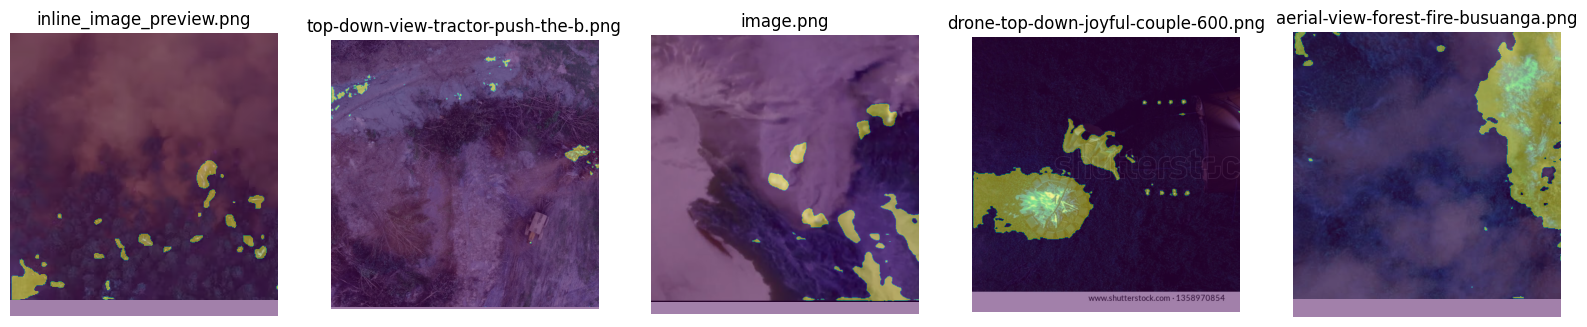

In [42]:
# Inference the model on all the test images as a grid on a singlee matplotlib figure 
fig, axs = plt.subplots(1, len(file_paths), figsize=(20, 20))
for i, file_path in enumerate(file_paths):
    og_img = cv2.imread(file_path)
    img = cv2.cvtColor(og_img, cv2.COLOR_BGR2RGB)
    img = pad_numpy_img_till_dims_by_32(img)
    # Inference the model
    pred_mask = inference_flame_model(model, img)
    # Convert the predicted mask to numpy array
    pred_mask = pred_mask.numpy()
    # Remove the padding
    pred_mask = pred_mask[:og_img.shape[1], :og_img.shape[0]]
    # Plot the image and the predicted mask
    axs[i].imshow(og_img)
    axs[i].imshow(pred_mask, alpha=0.5)
    axs[i].set_title(file_path.split("/")[-1])
    axs[i].set_axis_off()

In [ ]:
# input from backend: rgb and thermal image pair, with date, and coordinates
# what i output to the backend: inference output, which is an image of the same size as the input image, 
# with the same number of channels.
# meta_data to output to backend: is_hotspot
